In [1]:
!nvidia-smi

Mon Nov 25 19:36:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8             10W /   80W |     206MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
from inference import get_model

PLAYER_DETECTION_MODEL_ID = ''
PLAYER_DETECTION_MODEL = get_model( model_id = PLAYER_DETECTION_MODEL_ID,
                                   api_key = '')

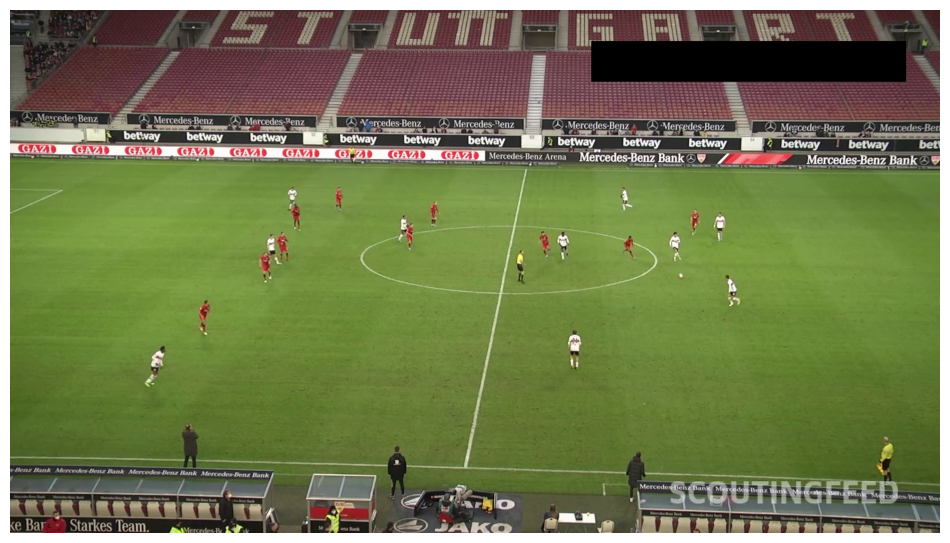

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "0bfacc_0.mp4"
TARGET_VIDEO_PATH = "573e61_0_result_1.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH,start=20)
frame = next(frame_generator)



sv.plot_image(frame)

## Video Game Style Visualization

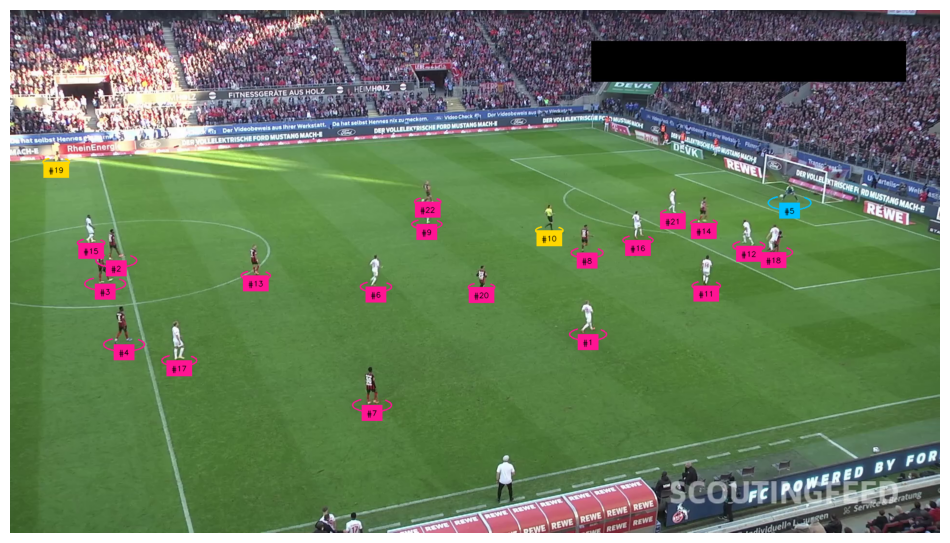

In [6]:
import supervision as sv

SOURCE_VIDEO_PATH = "573e61_0.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [7]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "573e61_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 25it [01:29,  3.58s/it]


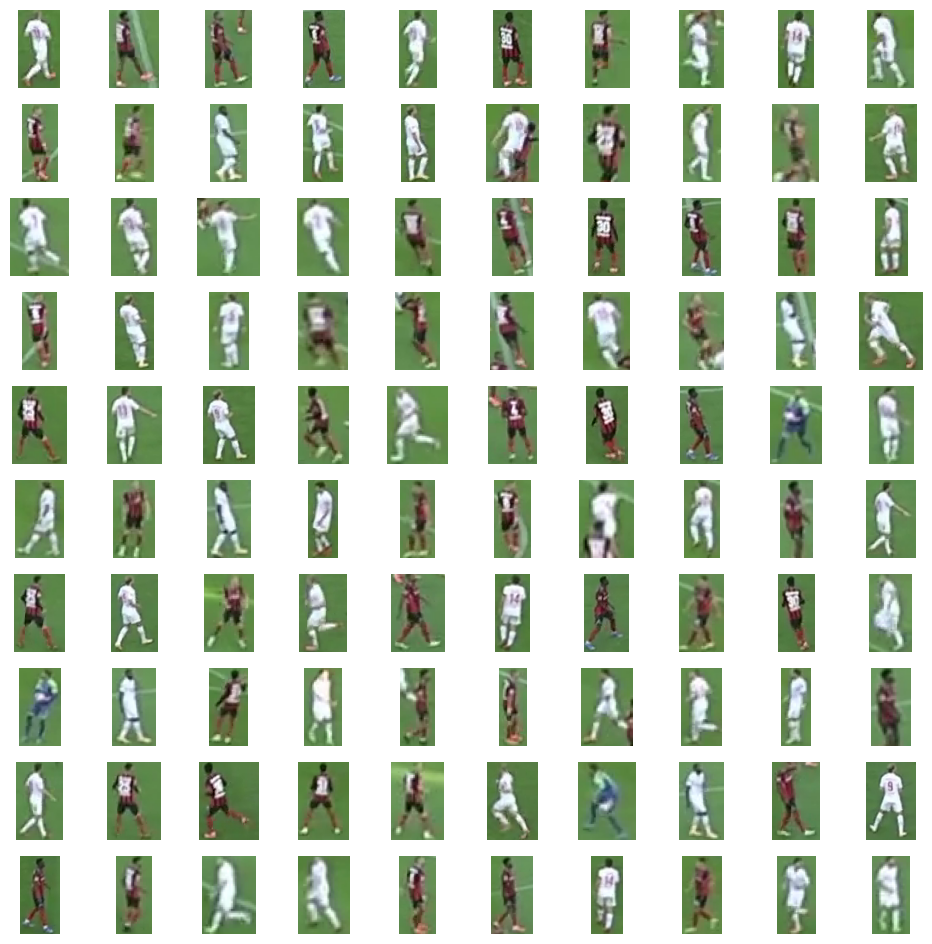

In [8]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [9]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

cuda


In [10]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 16it [00:04,  3.95it/s]


In [11]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [12]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)


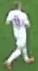
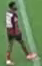
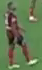
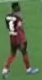
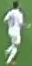
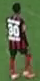
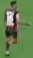
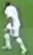
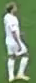
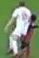
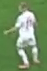
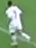
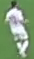
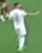
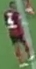
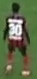
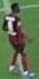
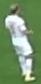
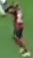
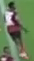
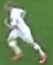
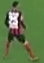
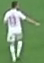
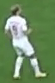
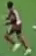
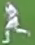
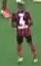
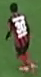
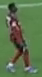
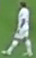
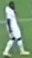
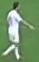
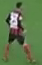
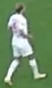
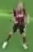
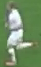
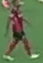
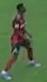
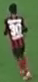
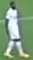
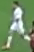
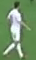
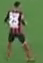
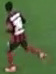
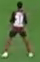
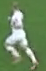
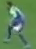
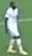
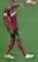
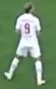
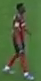
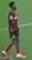
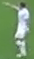
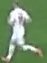
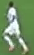
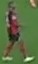
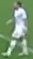
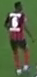
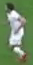
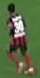
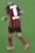
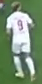
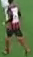
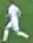
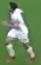
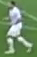
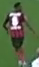
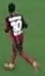
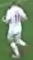
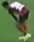
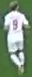
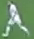
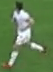
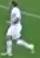
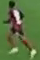
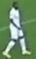
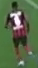
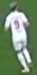
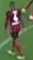
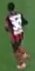
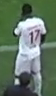
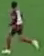
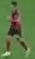
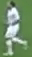
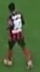
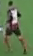
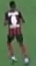
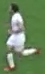
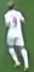
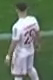
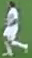
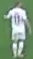
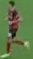
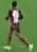
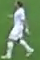
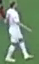
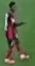
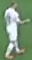
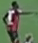
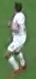
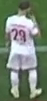
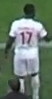
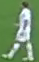
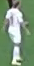
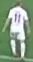
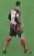
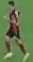
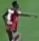
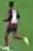
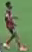
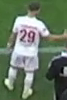
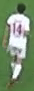
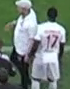
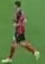
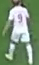
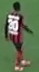
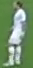
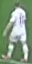
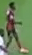
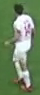
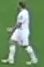
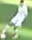
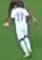
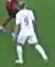
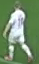
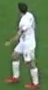
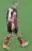
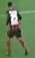
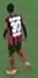
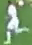
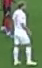
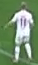
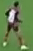
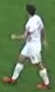
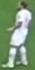
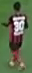
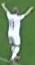
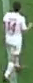
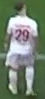
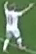
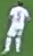
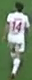
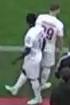
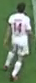
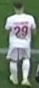
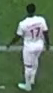
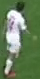
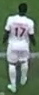
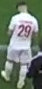
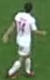
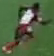
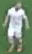
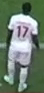
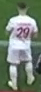
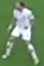
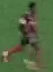
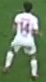
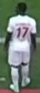
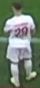
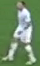
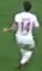
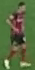
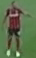
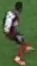
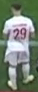
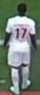
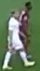
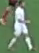
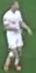
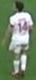
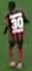
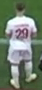
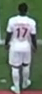
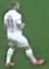
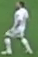
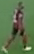
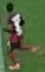
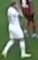
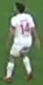
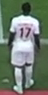
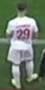
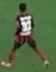
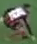
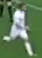
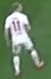
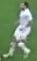
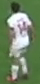
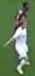

In [16]:
import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.display import display, HTML
from PIL import Image
import base64
from io import BytesIO


def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        function displayImage(imageId) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imageId];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        var chartElement = document.getElementById('scatter-plot-3d');

        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    display(HTML(html_template))

display_projections(clusters, projections, crops)

In [17]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "573e61_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [01:30,  3.63s/it]
Embedding extraction: 19it [00:04,  4.08it/s]


In [18]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:00,  5.34it/s]


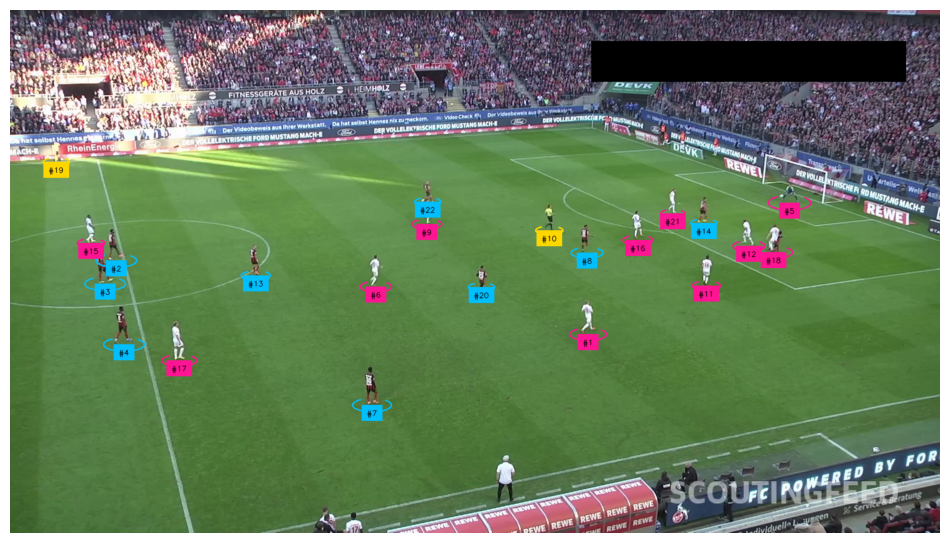

In [19]:
import supervision as sv

SOURCE_VIDEO_PATH = "573e61_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

### Pitch key point detection

In [22]:
from inference import get_model



FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/15"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key="0CdISE0z9dqV3E79UMpW")

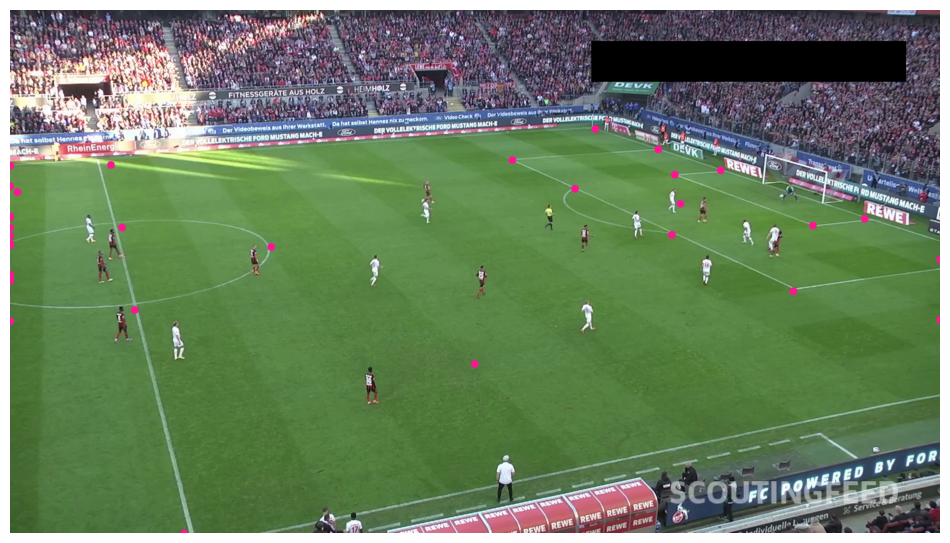

In [23]:
import supervision as sv

SOURCE_VIDEO_PATH = "573e61_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

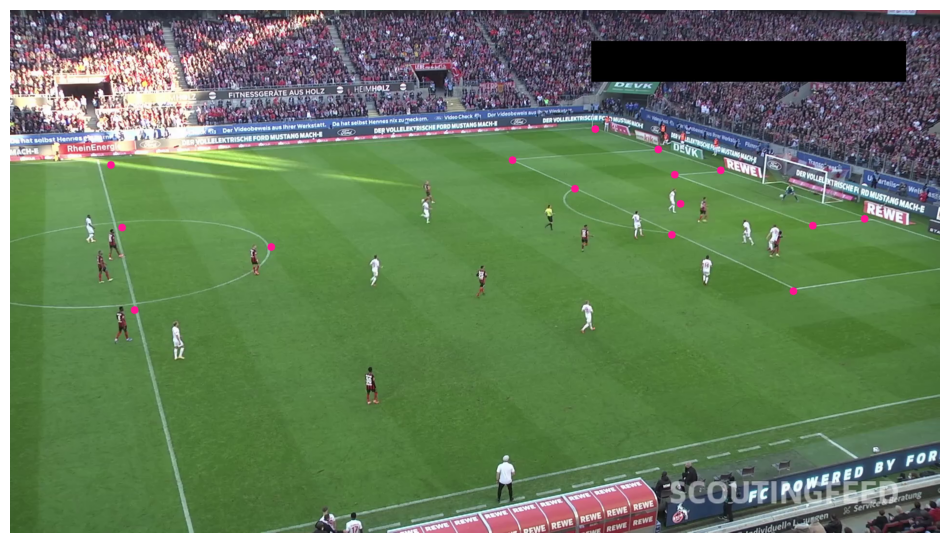

In [25]:
import supervision as sv

SOURCE_VIDEO_PATH = "573e61_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

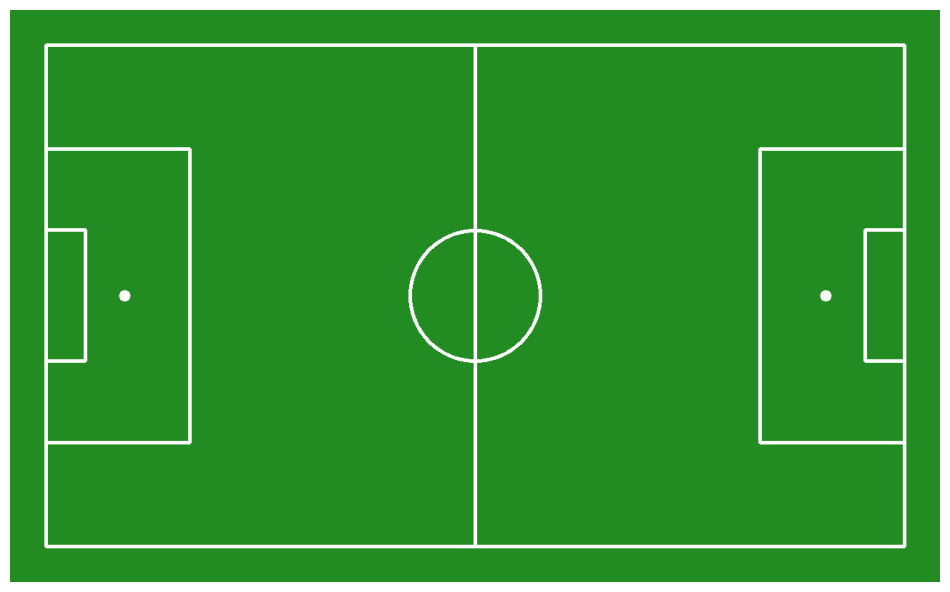

In [26]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

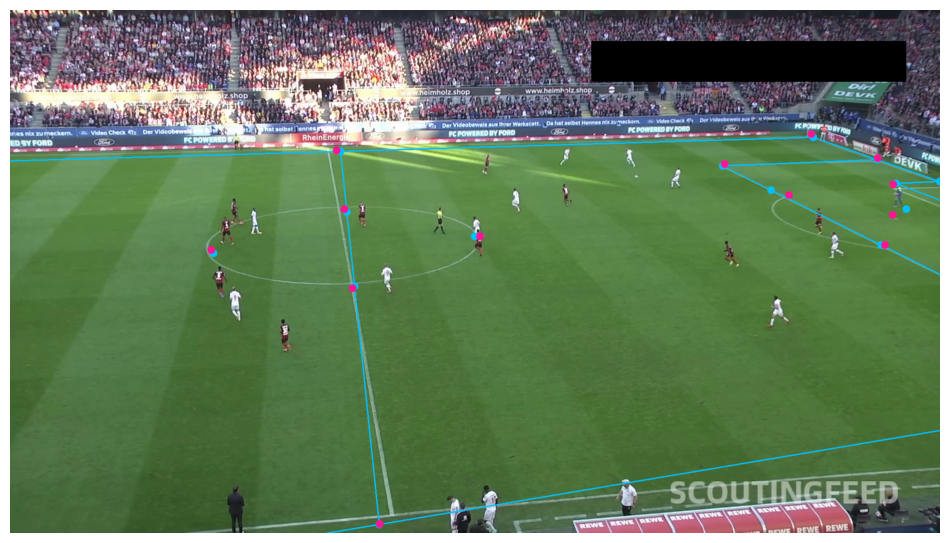

In [37]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "573e61_0.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [28]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "573e61_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [01:29,  3.60s/it]
Embedding extraction: 19it [00:04,  4.19it/s]


In [44]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "573e61_0.mp4"
TARGET_VIDEO_PATH = "573e61_0_result_2.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)



video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info2 = sv.VideoInfo(width = 1000, height = 800, fps=1, total_frames=30)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info2)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

with video_sink:
    for index, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):
        if index % 25 == 0 or index == 749:
            tracker = sv.ByteTrack()
            tracker.reset()
            # ball, goalkeeper, player, referee detection

            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
            detections = sv.Detections.from_inference(result)

            ball_detections = detections[detections.class_id == BALL_ID]
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

            all_detections = detections[detections.class_id != BALL_ID]
            all_detections = all_detections.with_nms(threshold=0.3, class_agnostic=True)
            all_detections = tracker.update_with_detections(detections=all_detections)

            goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
            players_detections = all_detections[all_detections.class_id == PLAYER_ID]
            referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

            # team assignment

            players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
            players_detections.class_id = team_classifier.predict(players_crops)

            goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
                players_detections, goalkeepers_detections)

            referees_detections.class_id -= 1

            all_detections = sv.Detections.merge([
                players_detections, goalkeepers_detections, referees_detections])



            # detect pitch key points

            result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
            key_points = sv.KeyPoints.from_inference(result)

            # project ball, players and referies on pitch

            filter = key_points.confidence[0] > 0.5
            frame_reference_points = key_points.xy[0][filter]
            pitch_reference_points = np.array(CONFIG.vertices)[filter]

            transformer = ViewTransformer(
                source=frame_reference_points,
                target=pitch_reference_points
            )

            frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
            pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

            players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
            pitch_players_xy = transformer.transform_points(points=players_xy)

            referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
            pitch_referees_xy = transformer.transform_points(points=referees_xy)

            # visualize video game-style radar view

            annotated_frame = draw_pitch(CONFIG)
            annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_ball_xy,
                face_color=sv.Color.WHITE,
                edge_color=sv.Color.BLACK,
                radius=10,
                pitch=annotated_frame)
            annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 0],
                face_color=sv.Color.from_hex('00BFFF'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame)
            annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 1],
                face_color=sv.Color.from_hex('FF1493'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame)
            annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_referees_xy,
                face_color=sv.Color.from_hex('FFD700'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame)

            #sv.plot_image(annotated_frame)
            output_directory = "./573e61_0"  # Change this to your desired directory
            output_file = os.path.join(output_directory, f"frame_{index}.png")  # Full path to save the image
            image = Image.fromarray(annotated_frame)# Convert NumPy array to a PIL image
            image.save(output_file)  # Save the image

            # Add a new column for the class (1 if True, 0 if False)
            class_column = players_detections.class_id.astype(np.float32)  # Convert True/False to 1/0

            # Combine the positions and the class column
            combined_data = np.hstack((pitch_players_xy, class_column[:, np.newaxis])).astype(np.float32)
            np.save(f"573e61_0/pitch_players_data_{index}.npy", combined_data)
            



Embedding extraction: 1it [00:00,  6.24it/s]
Embedding extraction: 1it [00:00,  5.25it/s]s/it]
Embedding extraction: 1it [00:00,  5.46it/s]t/s] 
Embedding extraction: 1it [00:00,  5.03it/s]t/s]
Embedding extraction: 1it [00:00,  4.83it/s]t/s]
Embedding extraction: 1it [00:00,  4.78it/s]it/s]
Embedding extraction: 1it [00:00,  4.57it/s]it/s]
Embedding extraction: 1it [00:00,  5.07it/s]it/s]
Embedding extraction: 1it [00:00,  4.75it/s]it/s]
Embedding extraction: 1it [00:00,  4.48it/s]it/s]
Embedding extraction: 1it [00:00,  5.04it/s]it/s]
Embedding extraction: 1it [00:00,  4.73it/s]it/s]
Embedding extraction: 1it [00:00,  4.82it/s]it/s]
Embedding extraction: 1it [00:00,  4.91it/s]it/s]
Embedding extraction: 1it [00:00,  4.75it/s]it/s]
Embedding extraction: 1it [00:00,  5.64it/s]it/s]
Embedding extraction: 1it [00:00,  5.96it/s]it/s]
Embedding extraction: 1it [00:00,  5.29it/s]it/s]
Embedding extraction: 1it [00:00,  5.02it/s]it/s]
Embedding extraction: 1it [00:00,  5.24it/s]it/s]
Embeddi

In [43]:
import cv2
import os

# Set the path to the folder containing the images
image_folder = "./573e61_0"
# Set the name and path for the output video file
video_name = 'radar_video.mp4'

# Get a list of all files in the image folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]

# Sort the images by name, especially to handle the numerical order
images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first image to get the size
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 1, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# Release the VideoWriter
video.release()

print(f'Video saved as {video_name}')


Video saved as radar_video.mp4


In [10]:
def find_longest_consecutive_sequence(lis):
    longest_sequence = []
    longest_start_index = 0
    longest_end_index = 0
    current_sequence = [lis[0]]
    current_start_index = 0

    for i in range(1, len(lis)):
        if lis[i] == lis[i-1] + 1:
            current_sequence.append(lis[i])
        else:
            if len(current_sequence) > len(longest_sequence):
                longest_sequence = current_sequence
                longest_start_index = current_start_index
                longest_end_index = i - 1
            current_sequence = [lis[i]]
            current_start_index = i

    # Check the last sequence
    if len(current_sequence) > len(longest_sequence):
        longest_sequence = current_sequence
        longest_start_index = current_start_index
        longest_end_index = len(lis) - 1

    return longest_sequence, longest_start_index, longest_end_index

# Example usage
lis = [24, 25,  30, 32, 33, 34, 35, 50, 51, 52, 53, 54]
longest_sequence, start_index, end_index = find_longest_consecutive_sequence(lis)
print(f'The longest consecutive sequence is: {longest_sequence}')
print(f'Start index: {start_index}, End index: {end_index}')



The longest consecutive sequence is: [50, 51, 52, 53, 54]
Start index: 7, End index: 11
